# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

## 1. Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

df = pd.read_csv('data/hotel_bookings.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3.0,0.0,2.0,NaN,Meal Plan 1,0.0,NaN,85.0,2018.0,8.0,3.0,Online,NaN,0.0,0.0,167.80,1.0,Not_Canceled
36271,INN36272,2.0,0.0,1.0,3.0,Meal Plan 1,0.0,Room_Type 1,228.0,2018.0,10.0,17.0,Online,0.0,0.0,0.0,90.95,2.0,Canceled
36272,INN36273,2.0,0.0,2.0,6.0,Meal Plan 1,0.0,Room_Type 1,148.0,2018.0,7.0,1.0,Online,0.0,0.0,0.0,98.39,2.0,Not_Canceled
36273,INN36274,2.0,0.0,0.0,3.0,Not Selected,0.0,Room_Type 1,63.0,2018.0,4.0,21.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


Before examining the data in detail, we need to check our dataset whether it has data quality issues.

**NOTE:** You can check the `hotel_cancelations_report.html` file for understanding the dataset using `pandas_profiling` library!

In [2]:
df.duplicated().sum()

0

In [3]:
df.isnull().sum()

Booking_ID                                 0
no_of_adults                             413
no_of_children                           324
no_of_weekend_nights                     367
no_of_week_nights                        807
type_of_meal_plan                        526
required_car_parking_space              2592
room_type_reserved                      1171
lead_time                                472
arrival_year                             378
arrival_month                            504
arrival_date                             981
market_segment_type                     1512
repeated_guest                           586
no_of_previous_cancellations             497
no_of_previous_bookings_not_canceled     550
avg_price_per_room                       460
no_of_special_requests                   789
booking_status                             0
dtype: int64

There is a lot of empty data. We need to organize it to get a useful format.

To do this, we will use `KNN Imputer` method for numerical data and `Mode Imputation` for categorical data.

In [4]:
from sklearn.impute import KNNImputer
impute = KNNImputer()

for column in df.select_dtypes('float64').columns:
    df[column] = impute.fit_transform(df[column].values.reshape(-1, 1)).astype(int)
    df[column] = df[column].astype(int)

In [5]:
df['type_of_meal_plan'].fillna('Not Selected', inplace=True)
df['room_type_reserved'].fillna('Room_Type 1', inplace=True)
df['market_segment_type'].fillna('Online', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Booking_ID                            36275 non-null  object
 1   no_of_adults                          36275 non-null  int64 
 2   no_of_children                        36275 non-null  int64 
 3   no_of_weekend_nights                  36275 non-null  int64 
 4   no_of_week_nights                     36275 non-null  int64 
 5   type_of_meal_plan                     36275 non-null  object
 6   required_car_parking_space            36275 non-null  int64 
 7   room_type_reserved                    36275 non-null  object
 8   lead_time                             36275 non-null  int64 
 9   arrival_year                          36275 non-null  int64 
 10  arrival_month                         36275 non-null  int64 
 11  arrival_date                

In [7]:
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,1,0,0,2,Not Selected,0,Room_Type 1,85,2017,7,15,Online,0,0,0,103,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,2,Meal Plan 1,0,Room_Type 1,85,2018,8,3,Online,0,0,0,167,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94,0,Canceled


What about label distribution? Is it imbalanced or not?

In [8]:
df['booking_status'].value_counts(normalize=True)

booking_status
Not_Canceled    0.672364
Canceled        0.327636
Name: proportion, dtype: float64

- It seems that there is imbalanced dataset. On the other hand, there is **not a significant difference** between them. So, if it necessary, we will cover this issue later.

Now, let's transform our labels to numeric data for examining the correlations with our features.

In [9]:
df['is_canceled'] = df['booking_status'].apply(lambda x: 1 if x=='Canceled' else 0) # Not_Canceled = 0, Canceled = 1
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,is_canceled
0,INN00001,1,0,0,2,Not Selected,0,Room_Type 1,85,2017,7,15,Online,0,0,0,103,0,Not_Canceled,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106,1,Not_Canceled,0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60,0,Canceled,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100,0,Canceled,1
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94,0,Canceled,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,2,Meal Plan 1,0,Room_Type 1,85,2018,8,3,Online,0,0,0,167,1,Not_Canceled,0
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90,2,Canceled,1
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98,2,Not_Canceled,0
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94,0,Canceled,1


## 2. Exploratory Data Analysis (EDA)

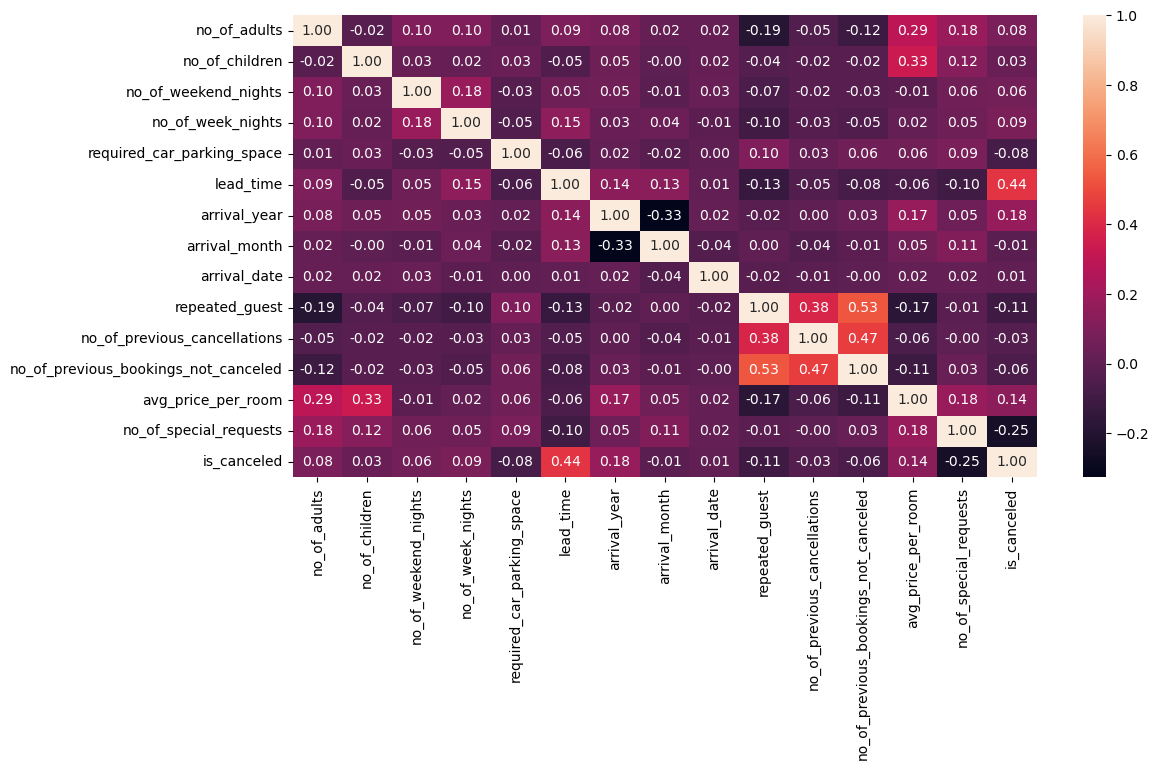

In [10]:
plt.figure(figsize=[12,6])
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f');

- When we analyze our correlation heatmap, we can ensure that there is **no strong multicollinearity problem between our features**.

- When we look into our target-features correlations, we can see that `lead_time` is a **most correlated feature with our label**.

So, let's examine it more detail.

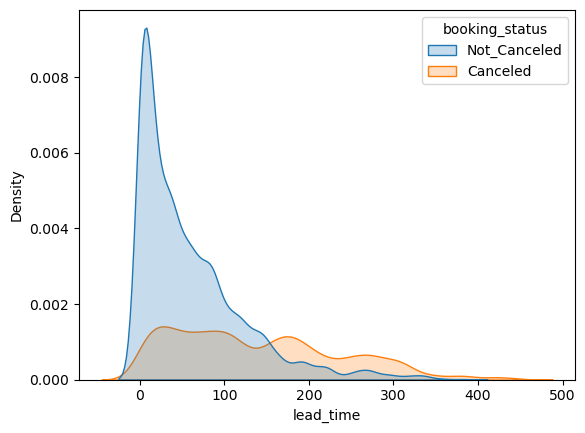

In [11]:
sns.kdeplot(x=df['lead_time'], hue=df['booking_status'], fill=True);

- In the chart above, we can clearly see that when our customers booked their hotel **3 months or earlier**, it causes **more booking cancellation**.

So important information! Let's go further and investigate the `no_of_special_requests` feature.

In [12]:
special_requests = df.groupby(['no_of_special_requests','booking_status'])['Booking_ID'].count().reset_index()
special_requests

,no_of_special_requests,booking_status,Booking_ID
0,0,Canceled,8621
1,0,Not_Canceled,11518
2,1,Canceled,2641
3,1,Not_Canceled,8484
4,2,Canceled,623
5,2,Not_Canceled,3650
6,3,Not_Canceled,653
7,4,Not_Canceled,77
8,5,Not_Canceled,8


In [13]:
fig1 = px.bar(x=special_requests['no_of_special_requests'], y=special_requests['Booking_ID'],
              color=special_requests['booking_status'], barmode='group')

fig1.update_layout(xaxis_title='Number of Special Requests', yaxis_title='Number of Customers', legend_title_text='Cancellation Status')

fig1.show()

- In the chart above, we can clearly see that when our customers **requested more and more**, it helps us to **prevent booking cancellations**.

Alright, is there any significant difference between **2017 and 2018**?

In [14]:
year_cancelations = df.groupby(['arrival_year','booking_status'])['Booking_ID'].count().reset_index()
year_cancelations

,arrival_year,booking_status,Booking_ID
0,2017,Canceled,1068
1,2017,Not_Canceled,5756
2,2018,Canceled,10817
3,2018,Not_Canceled,18634


In [15]:
fig2 = px.pie(names=year_cancelations[year_cancelations['arrival_year']==2017]['booking_status'],
             values=year_cancelations[year_cancelations['arrival_year']==2017]['Booking_ID'],
             title='Customer Cancellation Status in 2017')

fig2.update_layout(legend_title_text='Cancellation Status')

fig2.update_traces(textposition='inside', textinfo='percent+label')

fig2.show()

fig3 = px.pie(names=year_cancelations[year_cancelations['arrival_year']==2018]['booking_status'],
             values=year_cancelations[year_cancelations['arrival_year']==2018]['Booking_ID'],
             title='Customer Cancellation Status in 2018')

fig3.update_layout(legend_title_text='Cancellation Status')

fig3.update_traces(textposition='inside', textinfo='percent+label')

fig3.show()

In [16]:
year_cancelations_ct = pd.crosstab(index=year_cancelations['arrival_year'],
                                   columns=year_cancelations['booking_status'],
                                   values=year_cancelations['Booking_ID'], aggfunc='sum')
year_cancelations_ct

booking_status,Canceled,Not_Canceled
arrival_year,,
2017,1068,5756
2018,10817,18634


In [17]:
chi2_contingency(year_cancelations_ct)

Chi2ContingencyResult(statistic=1116.4232606138605, pvalue=8.900342284145159e-245, dof=1, expected_freq=array([[ 2235.78883529,  4588.21116471],
       [ 9649.21116471, 19801.78883529]]))

- The Chi-Square Independence Test shows that there is a **significant relationship** between `arrival_year` and `booking_status` variables.

And now, let's examine our categorical variables `type_of_meal_plan`, `room_type_reserved` and `market_segment_type`.

In [18]:
meal_plan_cancelations = df.groupby(['type_of_meal_plan','booking_status'])['Booking_ID'].count().reset_index()
meal_plan_cancelations

,type_of_meal_plan,booking_status,Booking_ID
0,Meal Plan 1,Canceled,8542
1,Meal Plan 1,Not_Canceled,18879
2,Meal Plan 2,Canceled,1488
3,Meal Plan 2,Not_Canceled,1778
4,Meal Plan 3,Canceled,1
5,Meal Plan 3,Not_Canceled,4
6,Not Selected,Canceled,1854
7,Not Selected,Not_Canceled,3729


In [19]:
fig4 = px.bar(x=meal_plan_cancelations['type_of_meal_plan'], y=meal_plan_cancelations['Booking_ID'],
              color=meal_plan_cancelations['booking_status'], barmode='group')

fig4.update_layout(xaxis_title='Type of Meal Plan', yaxis_title='Number of Customers', legend_title_text='Cancellation Status')

fig4.show()

- It seems that **the customers who has Meal Plan 2** are more likely to cancel their hotel bookings.

In [20]:
room_type_cancelations = df.groupby(['room_type_reserved','booking_status'])['Booking_ID'].count().reset_index()
room_type_cancelations

,room_type_reserved,booking_status,Booking_ID
0,Room_Type 1,Canceled,9166
1,Room_Type 1,Not_Canceled,19239
2,Room_Type 2,Canceled,218
3,Room_Type 2,Not_Canceled,446
4,Room_Type 3,Canceled,2
5,Room_Type 3,Not_Canceled,4
6,Room_Type 4,Canceled,1998
7,Room_Type 4,Not_Canceled,3853
8,Room_Type 5,Canceled,70
9,Room_Type 5,Not_Canceled,186


In [21]:
fig5 = px.bar(x=room_type_cancelations['room_type_reserved'], y=room_type_cancelations['Booking_ID'],
              color=room_type_cancelations['booking_status'], barmode='group')

fig5.update_layout(xaxis_title='Room Type', yaxis_title='Number of Customers', legend_title_text='Cancellation Status')

fig5.show()

- In the graph above, **room types of hotels are not significant effect** on hotel cancellations.

In [22]:
market_type_cancelations = df.groupby(['market_segment_type','booking_status'])['Booking_ID'].count().reset_index()
market_type_cancelations

,market_segment_type,booking_status,Booking_ID
0,Aviation,Canceled,36
1,Aviation,Not_Canceled,86
2,Complementary,Not_Canceled,375
3,Corporate,Canceled,204
4,Corporate,Not_Canceled,1722
5,Offline,Canceled,3023
6,Offline,Not_Canceled,7053
7,Online,Canceled,8622
8,Online,Not_Canceled,15154


In [23]:
fig6 = px.bar(x=market_type_cancelations['market_segment_type'], y=market_type_cancelations['Booking_ID'],
              color=market_type_cancelations['booking_status'], barmode='group')

fig6.update_layout(xaxis_title='Booking Type', yaxis_title='Number of Customers', legend_title_text='Cancellation Status')

fig6.show()

- The graph above shows that especially **Corporate** and **Complementary** bookings are less likely to cancel their holiday.
- **Corporate** bookings was paid by companies. This may be the reason for the low cancellation rate for this booking type.
- Additionally, **Complementary** bookings does not have any cancellation! That is not suprising, because every people loves free holiday :)

Lastly, let's examine the correlation values in our dataset with dummy data.

In [24]:
dummy_variables = pd.get_dummies(df, columns=df.select_dtypes('object').drop(columns=['Booking_ID','booking_status']).columns.to_list(), drop_first=True, dtype=int)
dummy_variables

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,...,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,INN00001,1,0,0,2,0,85,2017,7,15,...,0,0,0,0,0,0,0,0,0,1
1,INN00002,2,0,2,3,0,5,2018,11,6,...,0,0,0,0,0,0,0,0,0,1
2,INN00003,1,0,2,1,0,1,2018,2,28,...,0,0,0,0,0,0,0,0,0,1
3,INN00004,2,0,0,2,0,211,2018,5,20,...,0,0,0,0,0,0,0,0,0,1
4,INN00005,2,0,1,1,0,48,2018,4,11,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,2,0,85,2018,8,3,...,0,0,0,0,0,0,0,0,0,1
36271,INN36272,2,0,1,3,0,228,2018,10,17,...,0,0,0,0,0,0,0,0,0,1
36272,INN36273,2,0,2,6,0,148,2018,7,1,...,0,0,0,0,0,0,0,0,0,1
36273,INN36274,2,0,0,3,0,63,2018,4,21,...,0,0,0,0,0,0,0,0,0,1


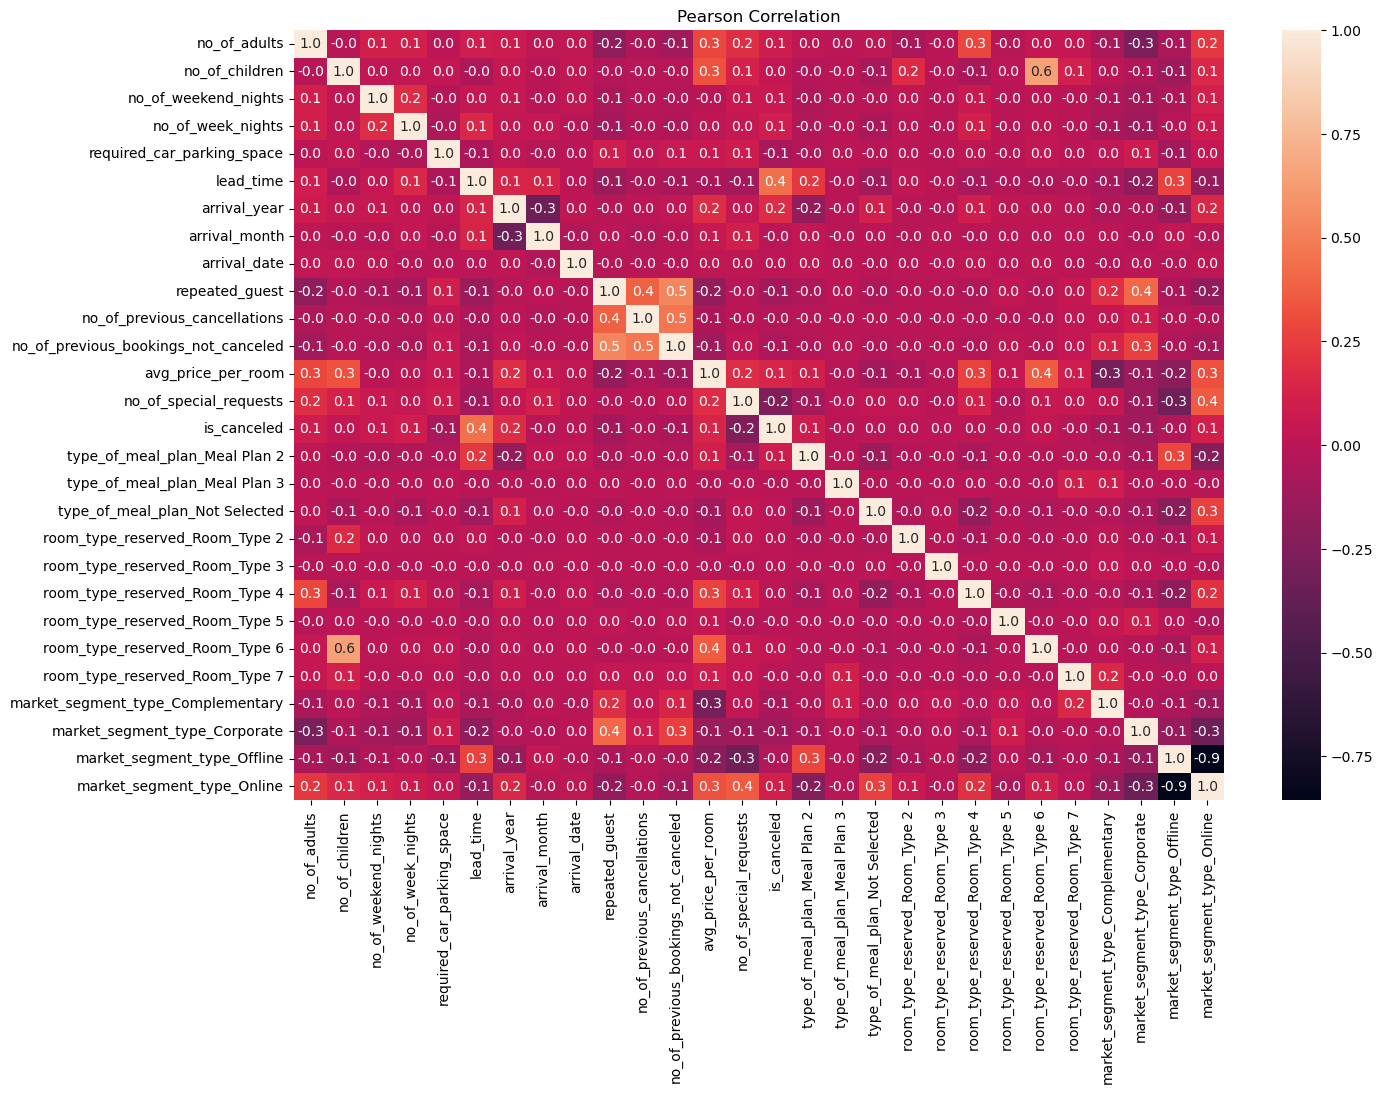

In [25]:
plt.figure(figsize=[15,10])
sns.heatmap(dummy_variables.corr(numeric_only=True), annot=True, fmt='.1f')
plt.title('Pearson Correlation');

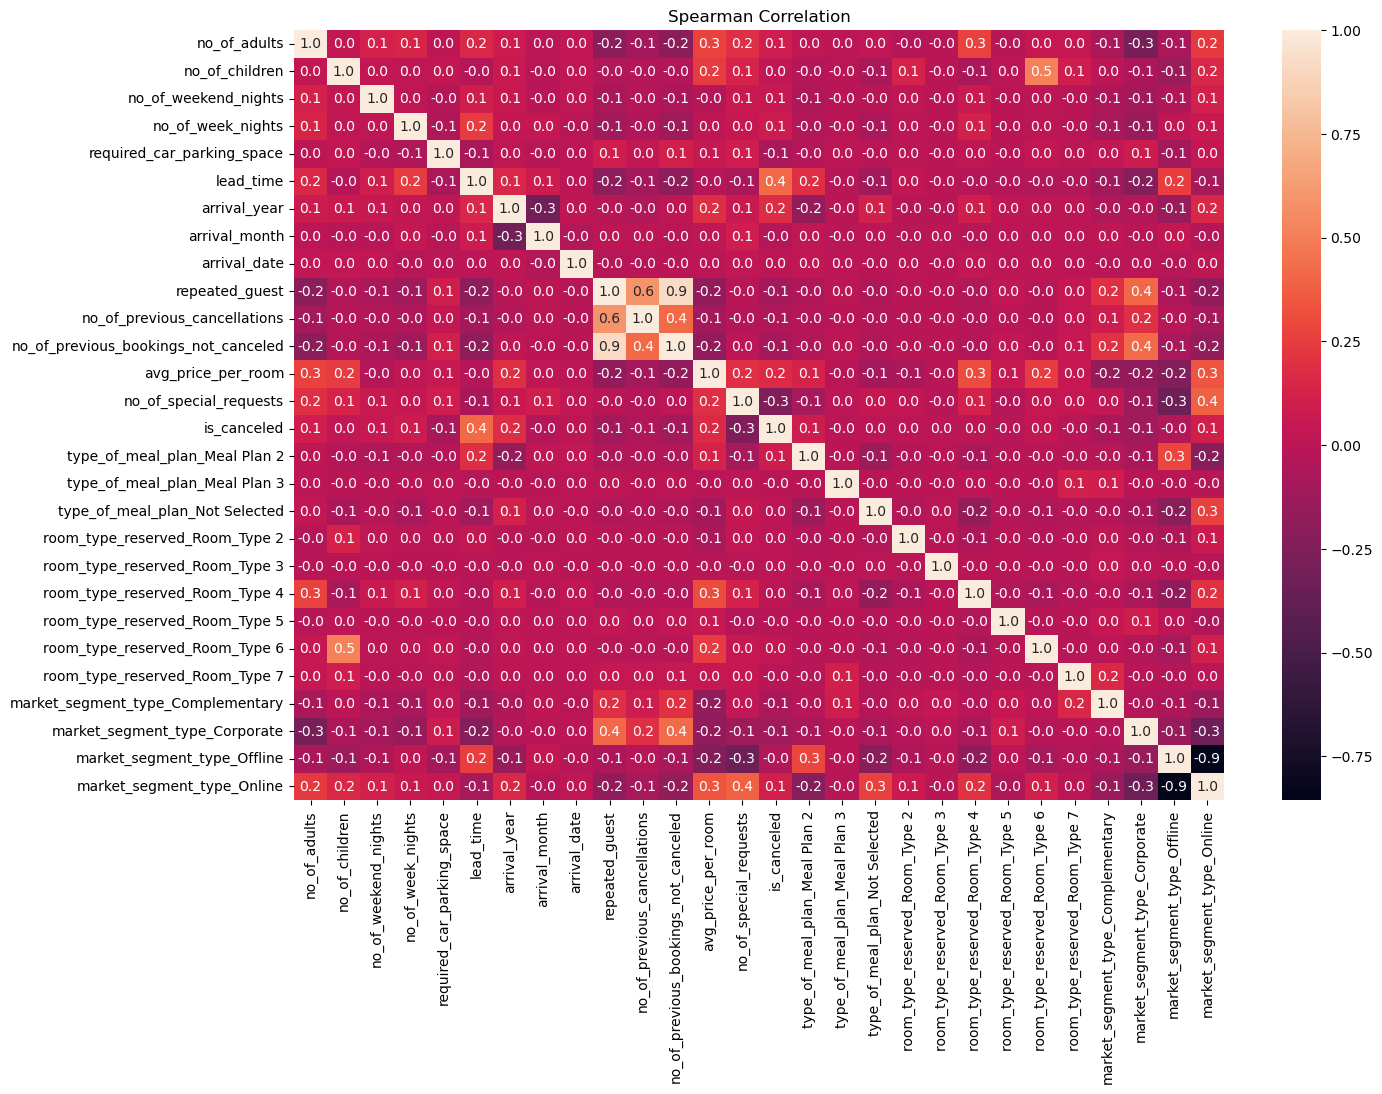

In [26]:
plt.figure(figsize=[15,10])
sns.heatmap(dummy_variables.corr(method='spearman', numeric_only=True), annot=True, fmt='.1f')
plt.title('Spearman Correlation');

- If we look more closely in `is_canceled` feature, the most correlated feature is `lead_time` (not suprising) and there are lots of features with low correlation values.

Also, there are some multicollinerity effects on our dataset. We will drop out after encode them.

Let's move to modeling.

## 3. Modelling

First of all, let's drop the features we will not use our model and rest of features one hot encode them for using it.

In [27]:
X = df.drop(columns=['Booking_ID', 'booking_status', 'repeated_guest', 'is_canceled'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
ohe = OneHotEncoder(drop='first', dtype=int, sparse_output=False)
encoded_train_features = ohe.fit_transform(X_train.select_dtypes('object'))
encoded_train_df = pd.DataFrame(encoded_train_features, columns=ohe.get_feature_names_out()).drop(columns='market_segment_type_Offline')
encoded_train_df

,type_of_meal_plan_Meal Plan 2,type_of_meal_plan_Meal Plan 3,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Online
0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29015,0,0,0,0,0,0,0,0,0,0,0,0
29016,1,0,0,0,0,0,0,0,0,0,0,1
29017,0,0,0,0,0,0,0,0,0,0,1,0
29018,0,0,0,0,0,0,0,0,0,0,0,1


In [29]:
X_train = pd.concat([X_train.reset_index(drop=True).select_dtypes(exclude='object'), encoded_train_df], axis=1)
y_train = y_train.reset_index(drop=True)
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,...,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Online
0,2,1,2,1,0,26,2017,10,17,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,1,0,98,2018,7,16,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,3,0,433,2018,9,8,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,2,5,0,195,2018,8,8,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,2,0,188,2018,6,15,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,2,0,2,2,0,43,2017,12,26,0,...,0,0,0,0,0,0,0,0,0,0
29016,1,0,0,2,0,102,2017,10,16,0,...,0,0,0,0,0,0,0,0,0,1
29017,2,0,0,2,0,5,2018,5,24,0,...,0,0,0,0,0,0,0,0,1,0
29018,2,0,0,3,0,213,2018,6,7,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
encoded_test_features = ohe.fit_transform(X_test.select_dtypes('object'))
encoded_test_df = pd.DataFrame(encoded_test_features, columns=ohe.get_feature_names_out()).drop(columns='market_segment_type_Offline')
X_test = pd.concat([X_test.reset_index(drop=True).select_dtypes(exclude='object'), encoded_test_df], axis=1)
y_test = y_test.reset_index(drop=True)
X_test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,no_of_previous_cancellations,...,type_of_meal_plan_Not Selected,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Online
0,2,1,1,0,0,3,2017,7,23,0,...,1,0,0,0,0,0,0,0,0,1
1,2,0,1,2,0,9,2018,2,12,0,...,0,0,0,1,0,0,0,0,0,0
2,2,0,2,2,0,24,2018,12,25,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,3,0,23,2018,6,21,0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,0,2,0,9,2018,9,8,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,2,0,0,3,0,190,2018,11,3,0,...,0,0,0,0,0,0,0,0,0,1
7251,2,0,0,2,0,0,2018,6,17,0,...,0,0,0,1,0,0,0,0,0,0
7252,2,0,0,2,0,30,2018,6,2,0,...,0,0,0,0,0,0,0,0,0,0
7253,2,0,1,2,0,39,2018,3,14,0,...,0,0,0,0,0,0,0,0,0,0


XGBoost is a powerfull algorithm for working with tabular data. So, we can continue with it.

In [31]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

0.9115437629221227

In [32]:
xgb.score(X_test, y_test)

0.8833907649896623

Our first training and testing results are **look good on accuracy metric**. But we must examine our model more detailed. Let's look at the confusion matrix.

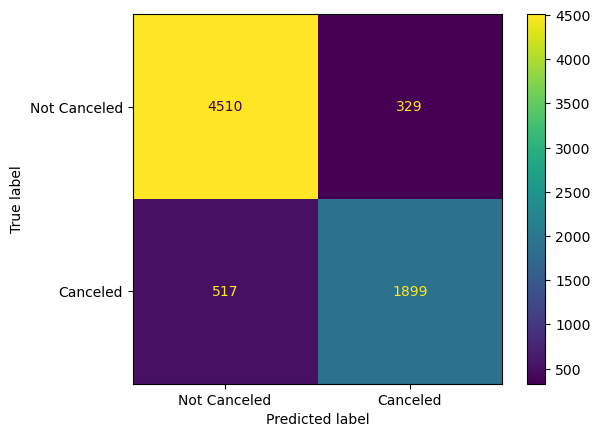

In [33]:
pred = xgb.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=['Not Canceled','Canceled']).plot();

We can clearly say that our model performance is better on **the customers who did not cancel their booking**. For better understading, let's cross validate our model on **F1 metric**.

In [34]:
cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')

array([0.80862832, 0.82090365, 0.80825638, 0.79225736, 0.80662983])

Its F1 score results are quiet close. But can we predict **the customers who did cancel their booking better**?

Now let's try to create better one.

In [35]:
result = permutation_importance(xgb, X_train, y_train,
                                scoring='f1', n_repeats=10, random_state=42)

pi_importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)
pi_importances

lead_time                               0.333095
no_of_special_requests                  0.183500
avg_price_per_room                      0.173927
market_segment_type_Online              0.088652
arrival_month                           0.064340
arrival_date                            0.034907
arrival_year                            0.023908
no_of_weekend_nights                    0.021230
no_of_week_nights                       0.020061
no_of_adults                            0.016688
required_car_parking_space              0.009173
type_of_meal_plan_Not Selected          0.008261
room_type_reserved_Room_Type 4          0.006623
no_of_previous_bookings_not_canceled    0.004234
type_of_meal_plan_Meal Plan 2           0.003834
no_of_children                          0.003496
market_segment_type_Corporate           0.002582
room_type_reserved_Room_Type 2          0.002225
room_type_reserved_Room_Type 5          0.001041
room_type_reserved_Room_Type 6          0.000663
room_type_reserved_R

According to our permutation importance results, some features does not significant effect on our model predictions. For this reason, let's use **the features with higger permutation importance than 0.01**.

In [36]:
pi_importances = pi_importances[pi_importances >= 0.01]

fig8 = px.bar(x=pi_importances.index, y=pi_importances.values)

fig8.update_layout(xaxis_title='Features', yaxis_title='Permutation Importance')

fig8.show()

In [37]:
useful_features = pi_importances.index
useful_features

Index(['lead_time', 'no_of_special_requests', 'avg_price_per_room',
       'market_segment_type_Online', 'arrival_month', 'arrival_date',
       'arrival_year', 'no_of_weekend_nights', 'no_of_week_nights',
       'no_of_adults'],
      dtype='object')

In [38]:
X_train = X_train[useful_features]
X_test = X_test[useful_features]

And create our model again...

In [39]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_train, y_train)

0.9079600275671951

In [40]:
cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')

array([0.8009964 , 0.80948487, 0.80521597, 0.7966286 , 0.80487805])

In [41]:
xgb.score(X_test, y_test)

0.8753962784286698

Although dropping **about 50% of our features** from the model, our model performance **is not significantly effected**! That's a good move.

Now, let's tune our model for reaching better results.

Learning rate is generally more significant effect on XGBoost algorithm. Therefore, we tune it first, and then go further.

In [42]:
from sklearn.model_selection import GridSearchCV

lr_param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]}

# GridSearchCV kullanarak hiperparametre optimizasyonu
grid_search = GridSearchCV(estimator=xgb, param_grid=lr_param_grid, 
                           scoring='f1', cv=5, n_jobs=-1)

# Modeli eğitme
grid_search.fit(X_train, y_train)

# En iyi hiperparametreleri alma
grid_search.best_params_

{'learning_rate': 0.3}

In [43]:
grid_search.cv_results_['mean_test_score']

array([0.72173677, 0.78145991, 0.79135621, 0.79846857, 0.80344078,
       0.80262154])

In [44]:
param_grid = {
    'learning_rate': [0.3],
    'n_estimators': [100, 250, 500],
    'max_depth': [2, 4, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.25, 0.5],
}

# GridSearchCV kullanarak hiperparametre optimizasyonu
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='f1', cv=3, n_jobs=-1)

# Modeli eğitme
grid_search.fit(X_train, y_train)

# En iyi hiperparametreleri alma
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 10,
 'n_estimators': 100,
 'subsample': 1.0}

In [45]:
best_xgb = grid_search.best_estimator_
best_xgb.score(X_test, y_test)

0.8890420399724328

Our **testing accuracy** score is so close to 0.89. Let's examine our confusion matrix after some improvements.

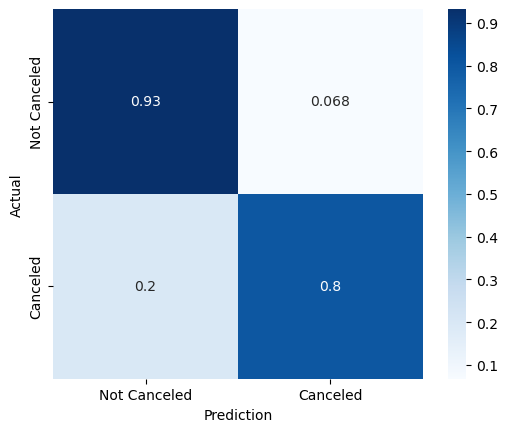

In [46]:
def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    y_pred = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Not Canceled','Canceled'],
           yticklabels=['Not Canceled','Canceled']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    
make_confusion_matrix(best_xgb)

We get **nearly %2 percent improvement on recall** for **the customers who did cancel their booking**.

If we change the threshold value of our model, can we get a better confusion matrix? Let's try.

In [47]:
from ipywidgets import interactive

interactive(lambda threshold: make_confusion_matrix(best_xgb, threshold), threshold=(0.0,1.0,0.05))
# Threshold = 0.3

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

For our purpose, **the confusion matrix with 0.3 threshold value** is predict the customers who did cancel their booking class better.

So, let's use it on our model.

In [48]:
predictions = (best_xgb.predict_proba(X_test)[:,1] > 0.3).astype(int)
test_df = pd.concat([X_test, y_test], axis=1)
test_df['prediction'] = predictions
test_df

,lead_time,no_of_special_requests,avg_price_per_room,market_segment_type_Online,arrival_month,arrival_date,arrival_year,no_of_weekend_nights,no_of_week_nights,no_of_adults,is_canceled,prediction
0,3,0,90,1,7,23,2017,1,0,2,0,0
1,9,0,48,0,2,12,2018,1,2,2,0,0
2,24,1,95,1,12,25,2018,2,2,2,0,0
3,23,0,127,1,6,21,2018,0,3,2,1,1
4,9,2,201,1,9,8,2018,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7250,190,0,90,1,11,3,2018,0,3,2,1,1
7251,0,1,90,0,6,17,2018,0,2,2,0,0
7252,30,0,140,0,6,2,2018,0,2,2,0,0
7253,39,0,85,0,3,14,2018,1,2,2,0,0


## 4. Model Explanation

Before completing our study, let's examine the **shap values** for better understanding on our model prediction behavior.

In [49]:
import shap

explainer = shap.Explainer(best_xgb)
shap_values_classification = explainer(X_test)

In [50]:
test_df

,lead_time,no_of_special_requests,avg_price_per_room,market_segment_type_Online,arrival_month,arrival_date,arrival_year,no_of_weekend_nights,no_of_week_nights,no_of_adults,is_canceled,prediction
0,3,0,90,1,7,23,2017,1,0,2,0,0
1,9,0,48,0,2,12,2018,1,2,2,0,0
2,24,1,95,1,12,25,2018,2,2,2,0,0
3,23,0,127,1,6,21,2018,0,3,2,1,1
4,9,2,201,1,9,8,2018,0,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7250,190,0,90,1,11,3,2018,0,3,2,1,1
7251,0,1,90,0,6,17,2018,0,2,2,0,0
7252,30,0,140,0,6,2,2018,0,2,2,0,0
7253,39,0,85,0,3,14,2018,1,2,2,0,0


In [51]:
shap.initjs()

For example, let's examine **the first observation** in our test dataset.

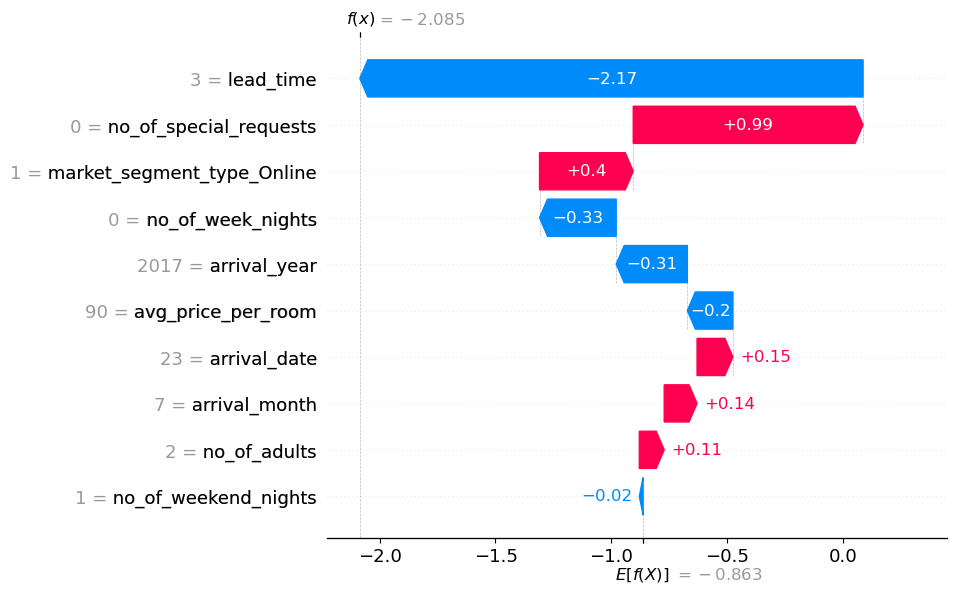

In [52]:
shap.plots.waterfall(shap_values_classification[0])

- Since our f(x) value is -2.085, we can say that our model predict the first observation to **Class 0 (Not Canceled)**.
- The most important feature for that observation is **booking was made of only 3 days before the arrival**! It became the most important factor for not canceled in that booking.

We can examine our observations like that. Awesome!

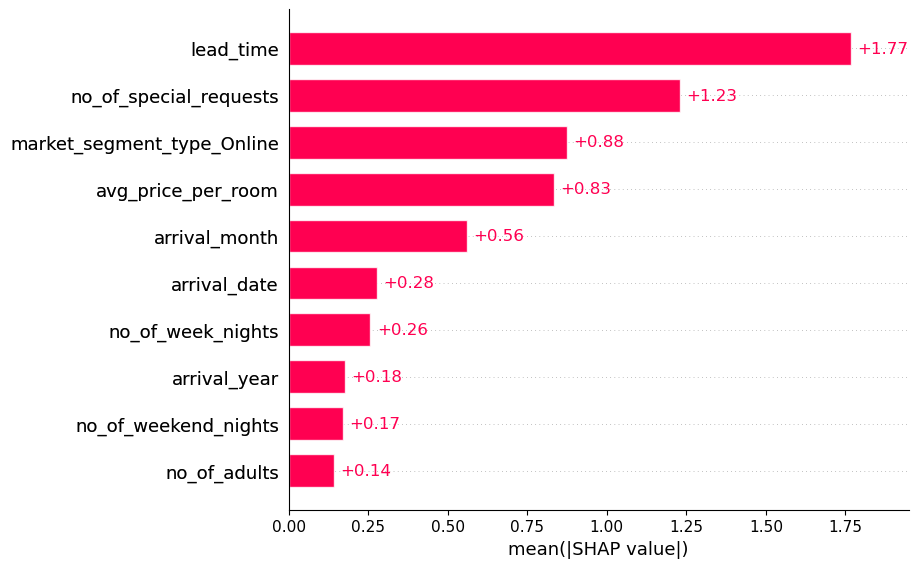

In [53]:
shap.plots.bar(shap_values_classification)

When we look the global feature explanation for our model, we can clearly see that features effects on model predictions in terms of their importance.

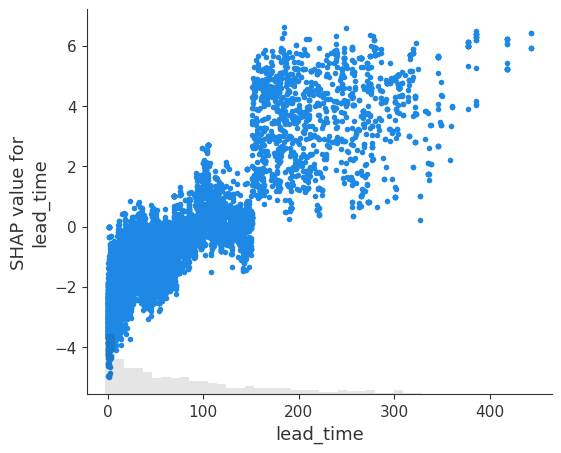

In [54]:
shap.plots.scatter(shap_values_classification[:, "lead_time"])

If we look the scatter plot above, we can confidently say that **when booking was made of long time ago before arrival, it can increases the cancelation probability**.

If we want to go further, we can examine all of the our features effect on the model prediction with **shap summary plot** below.

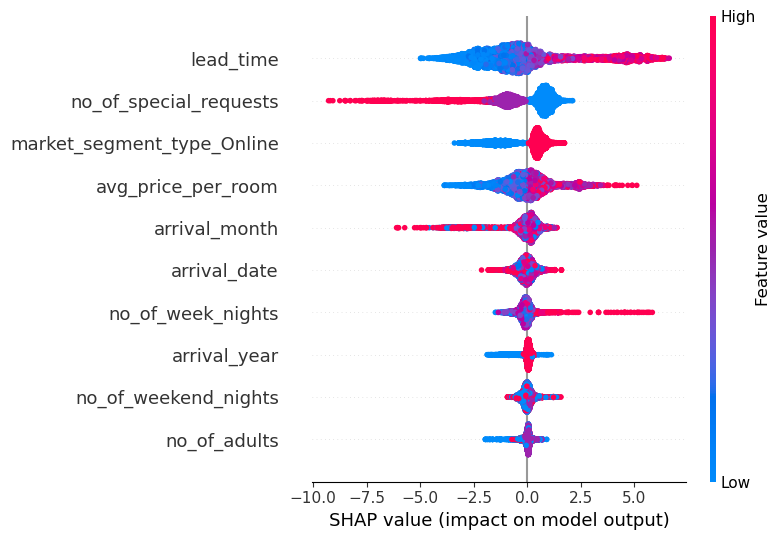

In [55]:
shap.summary_plot(shap_values_classification, X_test, feature_names=X_test.columns)